In [6]:
import math
import random
import time

import sklearn.metrics
from numpy import arange, c_
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
# from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import datasets
from sklearn.metrics import roc_auc_score, f1_score, balanced_accuracy_score

import scipy
from scipy import optimize

import numpy as np

from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay, RocCurveDisplay, roc_curve

import matplotlib.pyplot as plt

import pandas as pd

import seaborn as sns

sns.reset_orig()


noise = 16
samples = 2425
seed = 244825
classes = 2
train_split = 0.8
test_split = 0.2
repeats = 100

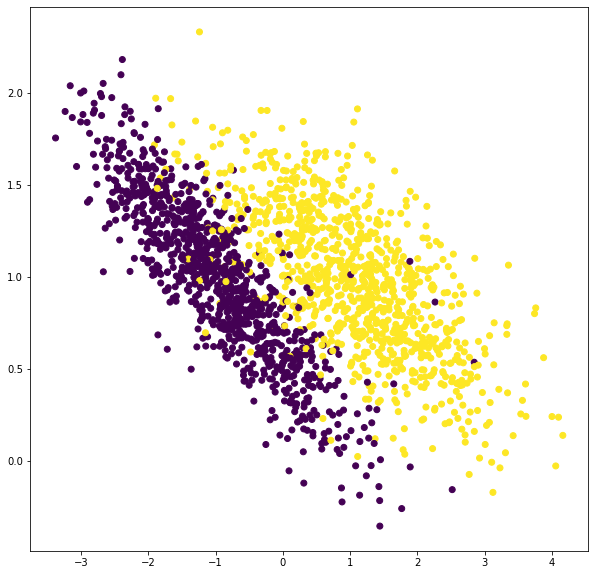

In [7]:
X, y = datasets.make_classification(n_features=2, random_state=seed, n_redundant=0, n_samples=samples, n_classes=2, n_clusters_per_class=1)

y[y == 0] = -1

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_split, test_size=test_split, random_state=seed)

xx, yy = np.meshgrid(np.arange(X.min(), X.max(), 0.01),
                       np.arange(X.min(), X.max(), 0.01))

plt.figure(figsize=(10,10))
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train)

Czulosc: 0.9180327868852459
Swoistosc: 0.8921161825726142
Accuracy: 0.9051546391752577
ROC auc: 0.9054468085106382
F1 score: 0.9068825910931175
BA score: 0.9054468085106383


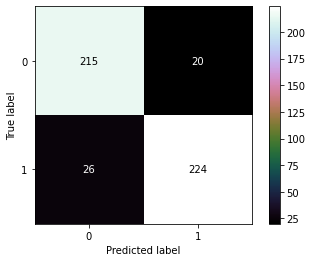

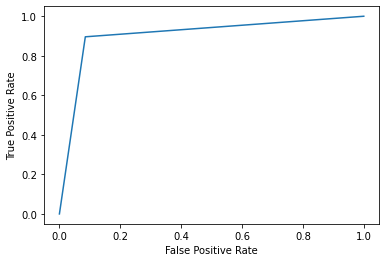

In [8]:
model = DecisionTreeClassifier()

model.fit(X_train, y_train)


y_pred = model.predict(X_test)

cm_model = confusion_matrix(y_test, y_pred, labels=[-1, 1])
tn_model = cm_model[0][0]
fn_model = cm_model[0][1]
tp_model = cm_model[1][1]
fp_model = cm_model[1][0]
ConfusionMatrixDisplay(cm_model).plot(cmap='cubehelix')

fpr, tpr, roc_auc = roc_curve(y_test, y_pred)

rok_model = RocCurveDisplay(fpr=fpr, tpr=tpr)
rok_model.plot()


print("Czulosc:", tp_model/(tp_model + fn_model))
print("Swoistosc:", tn_model/(tn_model + fp_model))
print("Accuracy:", (tp_model + tn_model) / (tp_model + tn_model + fp_model + fn_model))

print("ROC auc:", roc_auc_score(y_test, y_pred))
print("F1 score:", f1_score(y_test, y_pred))
print("BA score:", balanced_accuracy_score(y_test, y_pred))



In [9]:
class MyDecisionTreeClassifier():
    class Node():
        def __init__(self, feature_index=None, threshold=None, left=None, right=None, info_gain=None, value=None):
            ''' constructor '''

            # for decision node
            self.feature_index = feature_index
            self.threshold = threshold
            self.left = left
            self.right = right
            self.info_gain = info_gain

            # for leaf node
            self.value = value

    def __init__(self, min_samples_split=2, max_depth=2):
        ''' constructor '''

        # initialize the root of the tree
        self.root = None

        # stopping conditions
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth

    def build_tree(self, dataset, curr_depth=0):
        ''' recursive function to build the tree '''

        X, Y = dataset[:,:-1], dataset[:,-1]
        num_samples, num_features = np.shape(X)

        # split until stopping conditions are met
        if num_samples>=self.min_samples_split and curr_depth<=self.max_depth:
            # find the best split
            best_split = self.get_best_split(dataset, num_samples, num_features)
            # check if information gain is positive
            if best_split["info_gain"]>0:
                # recur left
                left_subtree = self.build_tree(best_split["dataset_left"], curr_depth+1)
                # recur right
                right_subtree = self.build_tree(best_split["dataset_right"], curr_depth+1)
                # return decision node
                return self.Node(best_split["feature_index"], best_split["threshold"],
                            left_subtree, right_subtree, best_split["info_gain"])

        # compute leaf node
        leaf_value = self.calculate_leaf_value(Y)
        # return leaf node
        return self.Node(value=leaf_value)

    def get_best_split(self, dataset, num_samples, num_features):
        ''' function to find the best split '''

        # dictionary to store the best split
        best_split = {}
        max_info_gain = -float("inf")

        # loop over all the features
        for feature_index in range(num_features):
            feature_values = dataset[:, feature_index]
            possible_thresholds = np.unique(feature_values)
            # loop over all the feature values present in the data
            for threshold in possible_thresholds:
                # get current split
                dataset_left, dataset_right = self.split(dataset, feature_index, threshold)
                # check if childs are not null
                if len(dataset_left)>0 and len(dataset_right)>0:
                    y, left_y, right_y = dataset[:, -1], dataset_left[:, -1], dataset_right[:, -1]
                    # compute information gain
                    curr_info_gain = self.information_gain(y, left_y, right_y, "gini")
                    # update the best split if needed
                    if curr_info_gain>max_info_gain:
                        best_split["feature_index"] = feature_index
                        best_split["threshold"] = threshold
                        best_split["dataset_left"] = dataset_left
                        best_split["dataset_right"] = dataset_right
                        best_split["info_gain"] = curr_info_gain
                        max_info_gain = curr_info_gain

        # return best split
        return best_split

    def split(self, dataset, feature_index, threshold):
        ''' function to split the data '''

        dataset_left = np.array([row for row in dataset if row[feature_index]<=threshold])
        dataset_right = np.array([row for row in dataset if row[feature_index]>threshold])
        return dataset_left, dataset_right

    def information_gain(self, parent, l_child, r_child, mode="entropy"):
        ''' function to compute information gain '''

        weight_l = len(l_child) / len(parent)
        weight_r = len(r_child) / len(parent)
        if mode=="gini":
            gain = self.gini_index(parent) - (weight_l*self.gini_index(l_child) + weight_r*self.gini_index(r_child))
        else:
            gain = self.entropy(parent) - (weight_l*self.entropy(l_child) + weight_r*self.entropy(r_child))
        return gain

    def entropy(self, y):
        ''' function to compute entropy '''

        class_labels = np.unique(y)
        entropy = 0
        for cls in class_labels:
            p_cls = len(y[y == cls]) / len(y)
            entropy += -p_cls * np.log2(p_cls)
        return entropy

    def gini_index(self, y):
        ''' function to compute gini index '''

        class_labels = np.unique(y)
        gini = 0
        for cls in class_labels:
            p_cls = len(y[y == cls]) / len(y)
            gini += p_cls**2
        return 1 - gini

    def calculate_leaf_value(self, Y):
        ''' function to compute leaf node '''

        Y = list(Y)
        return max(Y, key=Y.count)

    def print_tree(self, tree=None, indent=" "):
        ''' function to print the tree '''

        if not tree:
            tree = self.root

        if tree.value is not None:
            print(tree.value)

        else:
            print("X_"+str(tree.feature_index), "<=", tree.threshold, "?", tree.info_gain)
            print("%sleft:" % (indent), end="")
            self.print_tree(tree.left, indent + indent)
            print("%sright:" % (indent), end="")
            self.print_tree(tree.right, indent + indent)

    def fit(self, X, Y):
        ''' function to train the tree '''

        # dataset = np.concatenate((X, Y), axis=1)
        dataset = np.column_stack((X, Y))
        self.root = self.build_tree(dataset)

    def predict(self, X):
        ''' function to predict new dataset '''

        preditions = [self.make_prediction(x, self.root) for x in X]
        return preditions

    def make_prediction(self, x, tree):
        ''' function to predict a single data point '''

        if tree.value!=None: return tree.value
        feature_val = x[tree.feature_index]
        if feature_val<=tree.threshold:
            return self.make_prediction(x, tree.left)
        else:
            return self.make_prediction(x, tree.right)

In [10]:
classifier = MyDecisionTreeClassifier(min_samples_split=3, max_depth=3)
classifier.fit(X_train,y_train)
classifier.print_tree()

X_0 <= -0.07833673409977837 ? 0.2320611248895158
 left:X_0 <= -0.6100414922548201 ? 0.023786469781390956
  left:X_1 <= 1.463753325379131 ? 0.007225022169094875
    left:X_0 <= -1.1087889026318563 ? 0.0031663958859866614
        left:-1.0
        right:-1.0
    right:X_0 <= -1.6511252656310091 ? 0.1341630308299689
        left:-1.0
        right:1.0
  right:X_1 <= 1.060656730701731 ? 0.3528918008596388
    left:X_1 <= 0.8646170710616954 ? 0.003161820797793466
        left:-1.0
        right:-1.0
    right:X_1 <= 1.0783037714512913 ? 0.02094875346260401
        left:1.0
        right:1.0
 right:X_1 <= 0.6070909918013764 ? 0.06962480623633532
  left:X_0 <= 0.9438713421730989 ? 0.32867935897366146
    left:X_0 <= 0.5533515679441487 ? 0.007019340140269642
        left:-1.0
        right:-1.0
    right:X_1 <= 0.004893343783494153 ? 0.06026785714285712
        left:-1.0
        right:1.0
  right:X_0 <= 0.42939400015677287 ? 0.010230109518340885
    left:X_1 <= 0.7029753652935151 ? 0.115934917

Czulosc: 0.9285714285714286
Swoistosc: 0.9313304721030042
Accuracy: 0.9298969072164949
ROC auc: 0.9297021276595744
F1 score: 0.9322709163346613
BA score: 0.9297021276595745


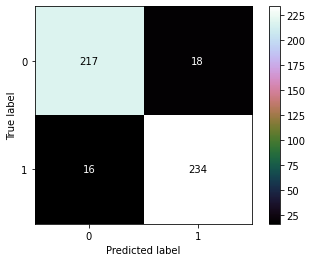

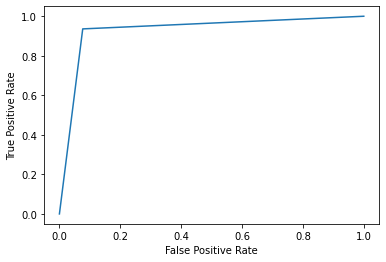

In [11]:
y_pred = classifier.predict(X_test)

cm_model = confusion_matrix(y_test, y_pred, labels=[-1, 1])
tn_model = cm_model[0][0]
fn_model = cm_model[0][1]
tp_model = cm_model[1][1]
fp_model = cm_model[1][0]
ConfusionMatrixDisplay(cm_model).plot(cmap='cubehelix')

fpr, tpr, roc_auc = roc_curve(y_test, y_pred)

rok_model = RocCurveDisplay(fpr=fpr, tpr=tpr)
rok_model.plot()


print("Czulosc:", tp_model/(tp_model + fn_model))
print("Swoistosc:", tn_model/(tn_model + fp_model))
print("Accuracy:", (tp_model + tn_model) / (tp_model + tn_model + fp_model + fn_model))

print("ROC auc:", roc_auc_score(y_test, y_pred))
print("F1 score:", f1_score(y_test, y_pred))
print("BA score:", balanced_accuracy_score(y_test, y_pred))

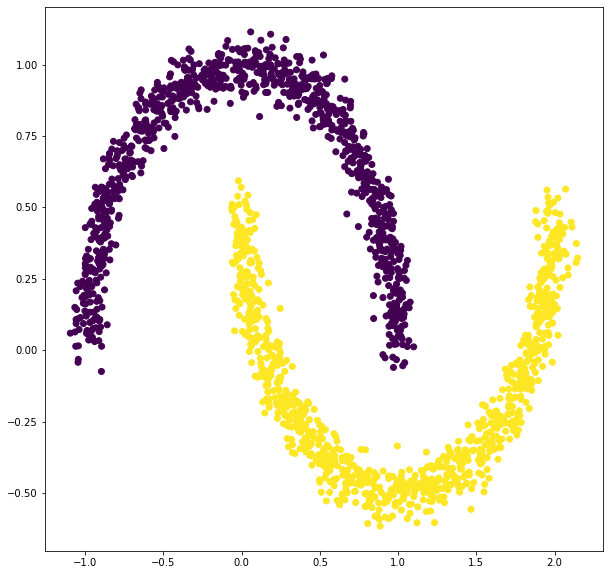

In [62]:
# X, y = datasets.make_classification(n_features=2, random_state=seed, n_redundant=0, n_samples=samples, n_classes=2, n_clusters_per_class=1)
X, y = datasets.make_moons(random_state=seed, n_samples=samples, noise=0.05)

y[y == 0] = -1

poly = PolynomialFeatures(degree=4, include_bias=False)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_split, test_size=test_split, random_state=seed, shuffle=True, stratify=y)

xx, yy = np.meshgrid(np.arange(X.min(), X.max(), 0.01),
                       np.arange(X.min(), X.max(), 0.01))

# X_train = my_normalize(X_train)
# X_test = my_normalize(X_test)
# X_train = poly.fit_transform(X_train)
# X_test = poly.fit_transform(X_test)


plt.figure(figsize=(10,10))
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train)

Czulosc: 1.0
Swoistosc: 1.0
Accuracy: 1.0
ROC auc: 1.0
F1 score: 1.0
BA score: 1.0


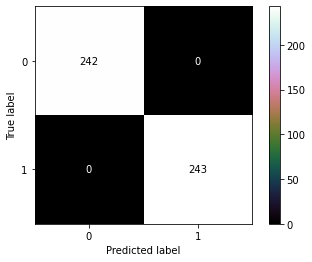

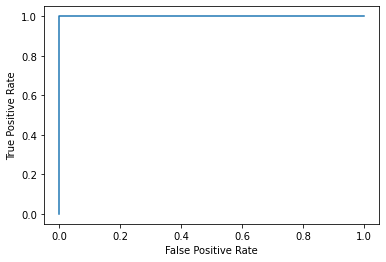

In [63]:
model = DecisionTreeClassifier()

model.fit(X_train, y_train)


y_pred = model.predict(X_test)

cm_model = confusion_matrix(y_test, y_pred, labels=[-1, 1])
tn_model = cm_model[0][0]
fn_model = cm_model[0][1]
tp_model = cm_model[1][1]
fp_model = cm_model[1][0]
ConfusionMatrixDisplay(cm_model).plot(cmap='cubehelix')

fpr, tpr, roc_auc = roc_curve(y_test, y_pred)

rok_model = RocCurveDisplay(fpr=fpr, tpr=tpr)
rok_model.plot()


print("Czulosc:", tp_model/(tp_model + fn_model))
print("Swoistosc:", tn_model/(tn_model + fp_model))
print("Accuracy:", (tp_model + tn_model) / (tp_model + tn_model + fp_model + fn_model))

print("ROC auc:", roc_auc_score(y_test, y_pred))
print("F1 score:", f1_score(y_test, y_pred))
print("BA score:", balanced_accuracy_score(y_test, y_pred))

X_1 <= 0.054623127224591714 ? 0.24370378498738637
 left:X_0 <= -0.8958420432385004 ? 0.028757287305703788
  left:-1.0
  right:X_1 <= -0.06222952400228876 ? 0.008618150062762273
    left:1.0
    right:X_0 <= 1.0993270868300098 ? 0.048577470203767736
        left:1.0
        right:1.0
 right:X_0 <= 1.0768857495371895 ? 0.15484719143196368
  left:X_1 <= 0.5219449780557186 ? 0.04712653088412283
    left:X_0 <= 0.24611707813382144 ? 0.10772554941991835
        left:-1.0
        right:-1.0
    right:X_1 <= 0.593328731019441 ? 0.0007499549305932229
        left:-1.0
        right:-1.0
  right:1.0
Czulosc: 0.9815668202764977
Swoistosc: 0.8880597014925373
Accuracy: 0.9298969072164949
ROC auc: 0.9300071421283542
F1 score: 0.9260869565217391
BA score: 0.9300071421283542


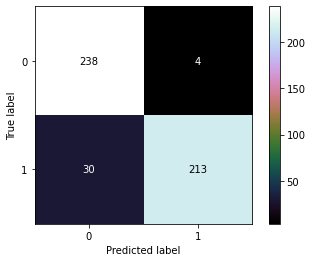

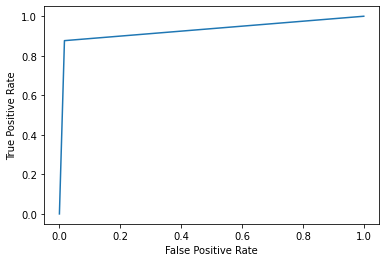

In [64]:
classifier = MyDecisionTreeClassifier(min_samples_split=3, max_depth=3)
classifier.fit(X_train,y_train)
classifier.print_tree()

y_pred = classifier.predict(X_test)

cm_model = confusion_matrix(y_test, y_pred, labels=[-1, 1])
tn_model = cm_model[0][0]
fn_model = cm_model[0][1]
tp_model = cm_model[1][1]
fp_model = cm_model[1][0]
ConfusionMatrixDisplay(cm_model).plot(cmap='cubehelix')

fpr, tpr, roc_auc = roc_curve(y_test, y_pred)

rok_model = RocCurveDisplay(fpr=fpr, tpr=tpr)
rok_model.plot()


print("Czulosc:", tp_model/(tp_model + fn_model))
print("Swoistosc:", tn_model/(tn_model + fp_model))
print("Accuracy:", (tp_model + tn_model) / (tp_model + tn_model + fp_model + fn_model))

print("ROC auc:", roc_auc_score(y_test, y_pred))
print("F1 score:", f1_score(y_test, y_pred))
print("BA score:", balanced_accuracy_score(y_test, y_pred))

In [51]:
data = pd.read_csv('HTRU_2.csv', names=[x for x in range(0, 9)], header=None, index_col=False)

# 1. Mean of the integrated profile.
# 2. Standard deviation of the integrated profile.
# 3. Excess kurtosis of the integrated profile.
# 4. Skewness of the integrated profile.
# 5. Mean of the DM-SNR curve.
# 6. Standard deviation of the DM-SNR curve.
# 7. Excess kurtosis of the DM-SNR curve.
# 8. Skewness of the DM-SNR curve.
# 9. Class

In [52]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17898 entries, 0 to 17897
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       17898 non-null  float64
 1   1       17898 non-null  float64
 2   2       17898 non-null  float64
 3   3       17898 non-null  float64
 4   4       17898 non-null  float64
 5   5       17898 non-null  float64
 6   6       17898 non-null  float64
 7   7       17898 non-null  float64
 8   8       17898 non-null  int64  
dtypes: float64(8), int64(1)
memory usage: 1.2 MB


In [53]:
data = data.dropna(axis=0, subset=[8])

medians = data.median(axis=0, numeric_only=True)
for index, value in medians.items():
    data[index].fillna(value, inplace=True)

data.head()

,0,1,2,3,4,5,6,7,8
0,140.562500,55.683782,-0.234571,-0.699648,3.199833,19.110426,7.975532,74.242225,0
1,102.507812,58.882430,0.465318,-0.515088,1.677258,14.860146,10.576487,127.393580,0
2,103.015625,39.341649,0.323328,1.051164,3.121237,21.744669,7.735822,63.171909,0
3,136.750000,57.178449,-0.068415,-0.636238,3.642977,20.959280,6.896499,53.593661,0
4,88.726562,40.672225,0.600866,1.123492,1.178930,11.468720,14.269573,252.567306,0


In [54]:
def winsorize(df):
    for i in df.columns:
        q1 = df[i].quantile(0.25)
        q3 = df[i].quantile(0.75)

        iqr = q3 - q1

        lower_bound = q1 - (1.5 * iqr)
        upper_bound = q3 + (1.5 * iqr)

        df.loc[df[i] < lower_bound, i] = lower_bound
        df.loc[df[i] > upper_bound, i] = upper_bound
    return df


def normalize(df):
    result = df.copy()
    for feature_name in df.columns:
        if df[feature_name].dtype == 'float64' or df[feature_name].dtype == 'int32':
            max_value = df[feature_name].max()
            min_value = df[feature_name].min()
            result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result



# data = winsorize(data)
data = normalize(data)
data

,0,1,2,3,4,5,6,7,8
0,0.721342,0.417687,0.165043,0.015627,0.013382,0.113681,0.294986,0.063890,0
1,0.517628,0.460908,0.235415,0.018268,0.006560,0.072524,0.364015,0.108443,0
2,0.520346,0.196868,0.221138,0.040677,0.013030,0.139188,0.288624,0.054610,0
3,0.700933,0.437884,0.181750,0.016534,0.015368,0.131583,0.266348,0.046581,0
4,0.443854,0.214847,0.249044,0.041712,0.004327,0.039684,0.462029,0.213369,0
...,...,...,...,...,...,...,...,...,...
17893,0.699218,0.473948,0.169741,0.015077,0.004855,0.046437,0.493364,0.241336,0
17894,0.624942,0.333936,0.201496,0.030260,0.072572,0.360761,0.161482,0.008612,0
17895,0.607712,0.475144,0.204652,0.015007,0.095069,0.498699,0.149653,0.005509,0
17896,0.581866,0.393617,0.208855,0.025283,0.007766,0.058209,0.348926,0.114181,0


In [55]:
data.corr().style.background_gradient(cmap='viridis')

,0,1,2,3,4,5,6,7,8
0,1.000000,0.547137,-0.873898,-0.738775,-0.298841,-0.307016,0.234331,0.144033,-0.673181
1,0.547137,1.000000,-0.521435,-0.539793,0.006869,-0.047632,0.029429,0.027691,-0.363708
2,-0.873898,-0.521435,1.000000,0.945729,0.414368,0.432880,-0.341209,-0.214491,0.791591
3,-0.738775,-0.539793,0.945729,1.000000,0.412056,0.415140,-0.328843,-0.204782,0.709528
4,-0.298841,0.006869,0.414368,0.412056,1.000000,0.796555,-0.615971,-0.354269,0.400876
5,-0.307016,-0.047632,0.432880,0.415140,0.796555,1.000000,-0.809786,-0.575800,0.491535
6,0.234331,0.029429,-0.341209,-0.328843,-0.615971,-0.809786,1.000000,0.923743,-0.390816
7,0.144033,0.027691,-0.214491,-0.204782,-0.354269,-0.575800,0.923743,1.000000,-0.259117
8,-0.673181,-0.363708,0.791591,0.709528,0.400876,0.491535,-0.390816,-0.259117,1.000000


In [56]:
from sklearn.model_selection import GridSearchCV

X = data.drop(axis=1, columns=8).to_numpy()
y = data[8].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=seed)

In [57]:
model_tree = DecisionTreeClassifier()
parameters = {'criterion': ('gini', 'entropy'),
              'max_depth': [x for x in range(1, 15)],
              'min_samples_split': [x for x in range(2, 5)],
              'min_samples_leaf': [x for x in range(1, 5)]}
clf = GridSearchCV(model_tree, parameters, n_jobs=4)

In [58]:
clf.fit(X_train, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(), n_jobs=4,
             param_grid={'criterion': ('gini', 'entropy'),
                         'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14],
                         'min_samples_leaf': [1, 2, 3, 4],
                         'min_samples_split': [2, 3, 4]})

In [59]:
print(clf.best_params_)

{'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 3, 'min_samples_split': 2}


In [60]:
y_predicted = clf.predict(X_test)

Czulosc: 0.8993288590604027
Swoistosc: 0.985679463741621
Accuracy: 0.9784916201117319
ROC auc: 0.9208026446923844
F1 score: 0.8743882544861339
BA score: 0.9208026446923843


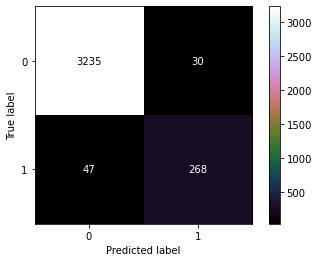

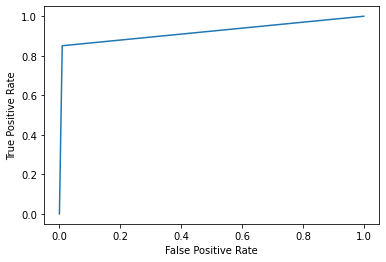

In [61]:
cm_model = confusion_matrix(y_test, y_predicted)
tn_model = cm_model[0][0]
fn_model = cm_model[0][1]
tp_model = cm_model[1][1]
fp_model = cm_model[1][0]
ConfusionMatrixDisplay(cm_model).plot(cmap='cubehelix')

fpr, tpr, roc_auc = roc_curve(y_test, y_predicted)

rok_model = RocCurveDisplay(fpr=fpr, tpr=tpr)
rok_model.plot()


print("Czulosc:", tp_model/(tp_model + fn_model))
print("Swoistosc:", tn_model/(tn_model + fp_model))
print("Accuracy:", (tp_model + tn_model) / (tp_model + tn_model + fp_model + fn_model))

print("ROC auc:", roc_auc_score(y_test, y_predicted))
print("F1 score:", f1_score(y_test, y_predicted))
print("BA score:", balanced_accuracy_score(y_test, y_predicted))